# Accelerometer Signal Analysis

In [1]:
# Import
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import os
import csv
from python_speech_features import mfcc
from python_speech_features import logfbank
plt.style.use('dark_background')

In [2]:
# Get the root path of the project
ROOT_DIR = os.path.relpath("C:/Temp/MeasureAccDone")
os.chdir(ROOT_DIR)
print(os.getcwd())

C:\Temp\MeasureAccDone


In [3]:
'''
Function : getDataFromFile
Param    : path to file
Return   : data_np -> Numpy array with all data (3 acc x 3 axis)
           hpfEnable -> return if the High Pass Filter was enabled during the measure
           FlowRate -> return the flow rate measured during the test
'''
def getDataFromFile(path):
    data = pd.read_csv(path, index_col=False , sep=';', skiprows=1, header=None)
    data_np = np.array(data, np.float64)

    with open(path) as csvFile:
        reader = csv.reader(csvFile, delimiter=';')
        field_names_list = next(reader)
        #print(field_names_list)
        hpfEnable = False
        if field_names_list[6] == 'HPF_Enable' :
            hpfEnable = True
        flowRate = field_names_list[10]
    
    return data_np, hpfEnable, flowRate

In [4]:
'''
Function : plotDataset
Param    : Dataset to display
Return   : None
'''
def plotDataset(dataset):
    for i in range (1,dataset.shape[1]) :
        plot_acc1 = dataset.loc['Acc1']
        plot_acc2 = dataset.loc['Acc2']
        plot_acc3 = dataset.loc['Acc3']
        column = dataset.columns.values[i]
        plt.plot(plot_acc1['FlowRate'], plot_acc1[column], 'ro',
                 plot_acc2['FlowRate'], plot_acc2[column], 'bs',
                 plot_acc3['FlowRate'], plot_acc3[column], 'g^')
        plt.legend(['Acc1', 'Acc2', 'Acc3'])
        plt.title(dataset.columns.values[i])
        plt.xlabel('FlowRate', fontsize=15)
        plt.xticks(rotation=90)
        plt.ylabel('Value', fontsize=15)
        plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
        plt.show()

In [5]:
'''
Function : plotHandledSignal
Param    : path -> path to the file
           pStd -> plot standard data
           pLow -> plot low-filtered data
           pFFT -> plot FFT data
           pHigh -> plot high-filterd data
           axis -> Select axis 'xyz'
           freq -> Cut-off frequency
           winSize -> number of sample by window
           winNb -> number of window
           peak -> true if the peaks must be calculated
Return   : None
'''
def plotHandledSignal(path, 
                      pStd=False, pLow=False, pFFT=False, pHigh=False, 
                      axis='xyz', freq=10, winSize=800, winNb=1, peak=True):
    # Retrieve data from file
    data_np, hpfEnable, flowRate = getDataFromFile(path)    
    print("FlowRate = ", flowRate)
    
    # Select the Axis to handle
    if axis == 'x' : 
        acc1 = data_np[0,:]
        acc2 = data_np[3,:]
        acc3 = data_np[6,:]
    elif axis == 'y' : 
        acc1 = data_np[1,:]
        acc2 = data_np[4,:]
        acc3 = data_np[7,:]
    elif axis == 'z' :
        acc1 = data_np[2,:]
        acc2 = data_np[5,:]
        acc3 = data_np[8,:]
    elif axis == 'xy' :
        acc1 = np.sqrt(np.power(data_np[0,:],2)+np.power(data_np[1,:],2))
        acc2 = np.sqrt(np.power(data_np[3,:],2)+np.power(data_np[4,:],2))
        acc3 = np.sqrt(np.power(data_np[6,:],2)+np.power(data_np[7,:],2))
    elif axis == 'yz' :
        acc1 = np.sqrt(np.power(data_np[1,:],2)+np.power(data_np[2,:],2))
        acc2 = np.sqrt(np.power(data_np[4,:],2)+np.power(data_np[5,:],2))
        acc3 = np.sqrt(np.power(data_np[7,:],2)+np.power(data_np[8,:],2))
    elif axis == 'xz' :
        acc1 = np.sqrt(np.power(data_np[0,:],2)+np.power(data_np[2,:],2))
        acc2 = np.sqrt(np.power(data_np[3,:],2)+np.power(data_np[5,:],2))
        acc3 = np.sqrt(np.power(data_np[6,:],2)+np.power(data_np[8,:],2))
    else : 
        acc1 = np.sqrt(np.power(data_np[0,:],2)+np.power(data_np[1,:],2)+np.power(data_np[2,:],2))
        acc2 = np.sqrt(np.power(data_np[3,:],2)+np.power(data_np[4,:],2)+np.power(data_np[5,:],2))
        acc3 = np.sqrt(np.power(data_np[6,:],2)+np.power(data_np[7,:],2)+np.power(data_np[8,:],2))
    
    # Display only a short window of data
    startPt = int(winSize * winNb)
    stopPt = int(winSize * winNb + winSize)

    # Perform a butterworth high-pass filter on the data
    b, a = signal.butter(8, freq, fs=800, btype='highpass')
    zi = signal.lfilter_zi(b, a)
    acc1_high = signal.lfilter(b, a, acc1, zi=None)
    acc2_high = signal.lfilter(b, a, acc2, zi=None)
    acc3_high = signal.lfilter(b, a, acc3, zi=None)
    
    # Perform a butterworth low-pass filter on the data
    b, a = signal.butter(8, freq, fs=800, btype='lowpass')
    #b, a = signal.cheby1(8, 3,freq, fs=800, btype='lowpass')
    #b, a = signal.bessel(8, freq, fs=800, btype='lowpass')
    #b, a = signal.ellip(10, 1, 1,freq, fs=800, btype='lowpass')
    zi = signal.lfilter_zi(b, a)
    acc1_low = signal.lfilter(b, a, acc1, zi=None)
    acc2_low = signal.lfilter(b, a, acc2, zi=None)
    acc3_low = signal.lfilter(b, a, acc3, zi=None) 
    
    # Frequency informations
    acc1_fft = np.fft.rfft(acc1)
    acc2_fft = np.fft.rfft(acc2)
    acc3_fft = np.fft.rfft(acc3)
    # Compute the module of complexes numbers
    acc1_Norm = np.sqrt(np.power(acc1_fft.real,2)+np.power(acc1_fft.imag,2))
    acc2_Norm = np.sqrt(np.power(acc2_fft.real,2)+np.power(acc2_fft.imag,2))
    acc3_Norm = np.sqrt(np.power(acc3_fft.real,2)+np.power(acc3_fft.imag,2))
    acc1_Freq = np.fft.rfftfreq(len(acc1),d=0.00125)
    acc2_Freq = np.fft.rfftfreq(len(acc2),d=0.00125)
    acc3_Freq = np.fft.rfftfreq(len(acc3),d=0.00125)
    acc1_Freq = acc1_Freq[acc1_Freq <= 400]
    acc2_Freq = acc2_Freq[acc2_Freq <= 400]
    acc3_Freq = acc3_Freq[acc3_Freq <= 400]
    acc1_Norm = acc1_Norm[:len(acc1_Freq)-1]
    acc2_Norm = acc2_Norm[:len(acc2_Freq)-1]
    acc3_Norm = acc3_Norm[:len(acc3_Freq)-1]
    
    condition = (acc1_Freq <= 200) & (acc1_Freq > 10)
    # Filter data which previous condition
    acc1_ess = acc1_Norm[np.where(condition)]
    acc2_ess = acc2_Norm[np.where(condition)]
    acc3_ess = acc3_Norm[np.where(condition)]
    
    acc1_ess_f = acc1_Freq[np.where(condition)]
    acc2_ess_f = acc2_Freq[np.where(condition)]
    acc3_ess_f = acc3_Freq[np.where(condition)]

    print("Max Norm 1 = ", acc1_ess.max(), "at freq ", acc1_ess_f[acc1_ess.argmax()])
    print("Max Norm 2 = ", acc2_ess.max(), "at freq ", acc2_ess_f[acc2_ess.argmax()])
    print("Max Norm 3 = ", acc3_ess.max(), "at freq ", acc3_ess_f[acc3_ess.argmax()])
    
    fig, (acc1_x, acc1_y, acc1_z) = plt.subplots(3, 1)
    fig.suptitle("FFT Filtered")
    acc1_x.plot(acc1_ess_f, acc1_ess)
    acc1_y.plot(acc2_ess_f, acc2_ess)
    acc1_z.plot(acc3_ess_f, acc3_ess)
    plt.show()
    
    # Find Peaks on the signal
    peak_feat = pd.DataFrame()    
    if peak:
        peak1, _ = find_peaks(acc1_low[startPt:stopPt], distance=1)
        peak2, _ = find_peaks(acc2_low[startPt:stopPt], distance=1)
        peak3, _ = find_peaks(acc3_low[startPt:stopPt], distance=1)
        diff1 = np.diff(peak1)
        diff2 = np.diff(peak2)
        diff3 = np.diff(peak3)
        diffAcc12 = []
        diffAcc23 = []
        for val in peak1[:len(peak1)-3] :
            iPeak2 = peak2[peak2 > val][0]
            iPeak3 = peak3[peak3 > iPeak2][0]
            diffAcc12 = np.append(diffAcc12, [iPeak2-val])
            diffAcc23 = np.append(diffAcc23, [iPeak3-iPeak2])
        print("peak1 : ", peak1)
        print("peak2 : ", peak2)
        print("peak3 : ", peak3)
        
        print("diffAcc12 : ", diffAcc12)
        print("diffAcc23 : ", diffAcc23)
    
        # Extract features from peaks and diff between peaks
        peak_feat['FlowRate'] = [flowRate,flowRate, flowRate]
        #peak_feat['DiffMin'] = [diff1.min(), diff2.min(), diff3.min()] 
        #peak_feat['DiffMax'] = [diff1.max(), diff2.max(), diff3.max()] 
        peak_feat['DiffMean'] = [diff1.mean(), diff2.mean(), diff3.mean()] 
        peak_feat['DiffMedian'] = [np.median(diff1), np.median(diff2), np.median(diff3)] 
        peak_feat['DiffRMS'] = [np.sqrt(sum(pow(diff1, 2)) / len(diff1)),
                                np.sqrt(sum(pow(diff2, 2)) / len(diff2)),
                                np.sqrt(sum(pow(diff3, 2)) / len(diff3))]
        peak_feat['DiffStdDev'] = [np.sqrt(sum(pow(diff1 - diff1.mean(), 2)) / len(diff1)),
                                    np.sqrt(sum(pow(diff2 - diff2.mean(), 2)) / len(diff2)),
                                    np.sqrt(sum(pow(diff3 - diff3.mean(), 2)) / len(diff3))]
        peak_feat['PeakMean'] = [peak1.mean(), peak2.mean(), peak3.mean()] 
        peak_feat['PeakMedian'] = [np.median(peak1), np.median(peak2), np.median(peak3)] 
        peak_feat['PeakRMS'] = [np.sqrt(sum(pow(peak1, 2)) / len(peak1)),
                                np.sqrt(sum(pow(peak2, 2)) / len(peak2)),
                                np.sqrt(sum(pow(peak3, 2)) / len(peak3))]
        peak_feat['PeakStdDev'] = [np.sqrt(sum(pow(peak1 - peak1.mean(), 2)) / len(peak1)),
                                    np.sqrt(sum(pow(peak2 - peak2.mean(), 2)) / len(peak2)),
                                    np.sqrt(sum(pow(peak3 - peak3.mean(), 2)) / len(peak3))]
        peak_feat['DiffAccMean'] = [diffAcc12.mean(), diffAcc23.mean(), (diffAcc12-diffAcc23).mean()]
        peak_feat['DiffAccMedian'] = [np.median(diffAcc12), np.median(diffAcc23), np.median(diffAcc12-diffAcc23)]
        peak_feat['DiffAccRMS'] =  [np.sqrt(sum(pow(diffAcc12, 2)) / len(diffAcc12)),
                                    np.sqrt(sum(pow(diffAcc23, 2)) / len(diffAcc23)),
                                    np.sqrt(sum(pow(peak3, 2)) / len(peak3))]
        peak_feat['DiffAccStdDev'] = [np.sqrt(sum(pow(diffAcc12 - diffAcc12.mean(), 2)) / len(diffAcc12)),
                                      np.sqrt(sum(pow(diffAcc23 - diffAcc23.mean(), 2)) / len(diffAcc23)),
                                      np.sqrt(sum(pow((diffAcc12-diffAcc23) - (diffAcc12-diffAcc23).mean(), 2)) / len((diffAcc12-diffAcc23)))]

        peak_feat.rename(index={0:'Acc1'}, inplace=True)
        peak_feat.rename(index={1:'Acc2'}, inplace=True)
        peak_feat.rename(index={2:'Acc3'}, inplace=True)
    
    # Display standard data
    if pStd :
        fig, (acc1_x, acc1_y, acc1_z) = plt.subplots(3, 1)
        fig.suptitle("Standard")
        acc1_x.plot(acc1[startPt:stopPt])
        acc1_y.plot(acc2[startPt:stopPt])
        acc1_z.plot(acc3[startPt:stopPt])
        plt.show()
    # Display Filtered signals
    if pHigh :
        fig, (acc1_plt, acc2_plt, acc3_plt) = plt.subplots(3, 1)
        fig.suptitle("High-Filtered Signal")
        acc1_plt.plot(acc1_high[startPt:stopPt])
        acc2_plt.plot(acc2_high[startPt:stopPt])
        acc3_plt.plot(acc3_high[startPt:stopPt])
        plt.show()
    # Display Filtered signals
    if pLow :
        fig, (acc1_plt, acc2_plt, acc3_plt) = plt.subplots(3, 1)
        fig.suptitle("LowFiltered Signal")
        acc1_plt.plot(acc1_low[startPt:stopPt])
        acc2_plt.plot(acc2_low[startPt:stopPt])
        acc3_plt.plot(acc3_low[startPt:stopPt])
        plt.show()
    # Display FFT data
    if pFFT :
        fig, (acc1_x, acc1_y, acc1_z) = plt.subplots(3, 1)
        fig.suptitle("FFT")
        acc1_x.plot(acc1_Freq[1:len(acc1_Norm)], acc1_Norm[1:])
        acc1_y.plot(acc2_Freq[1:len(acc1_Norm)], acc2_Norm[1:])
        acc1_z.plot(acc3_Freq[1:len(acc1_Norm)], acc3_Norm[1:])
        plt.show()
    
    return peak_feat, hpfEnable


### Show Signals

FlowRate =  1,300000
Max Norm 1 =  5671.69414560966 at freq  191.83266932270917
Max Norm 2 =  9119.3481909249 at freq  196.01593625498006
Max Norm 3 =  6633.008475857033 at freq  185.45816733067727


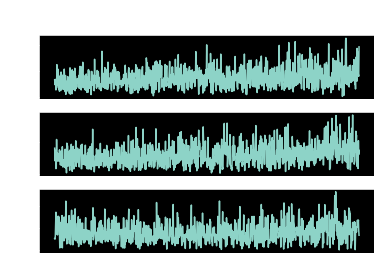

peak1 :  [  1  17  35  71  93 116 153 178 198 217 235 265 304 327 347 371 396 434
 457 483]
peak2 :  [  3  24  46  68 115 177 220 246 265 299 337 365 391 421 438 463 480]
peak3 :  [  3  15  49  76  93 119 156 174 208 244 280 317 359 387 401 422 461 483]
diffAcc12 :  [ 2.  7. 11. 44. 22. 61. 24. 42. 22.  3. 11. 34. 33. 10. 18. 20. 25.]
diffAcc23 :  [12. 25.  3.  4.  4. 31. 31. 24. 24. 24. 34. 18. 22. 22. 22. 10.  1.]


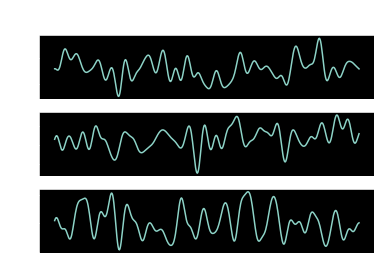

FlowRate =  2,900000
Max Norm 1 =  8306.680688042092 at freq  58.96414342629482
Max Norm 2 =  16167.165322377314 at freq  180.27888446215138
Max Norm 3 =  11964.093485681702 at freq  104.9800796812749


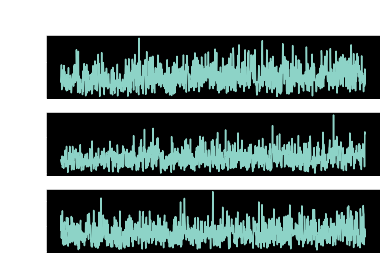

peak1 :  [ 20  44  65 106 129 148 171 192 206 233 255 277 325 362 395 412 440 483]
peak2 :  [ 27  56  80 112 133 155 175 194 213 249 270 294 318 345 367 385 428 442
 460 479 496]
peak3 :  [ 14  44  65  87 103 136 164 199 235 254 280 307 325 346 367 383 406 433
 461 492]
diffAcc12 :  [ 7. 12. 15.  6.  4.  7.  4.  2.  7. 16. 15. 17. 20.  5. 33.]
diffAcc23 :  [17.  9.  7. 24.  3.  9. 24.  5. 22.  5. 10. 13.  1. 16.  5.]


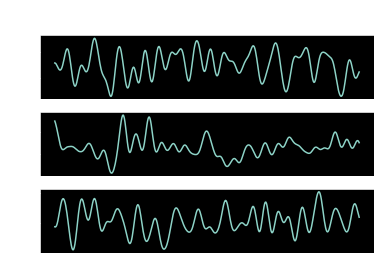

FlowRate =  5,000000
Max Norm 1 =  17847.831329441906 at freq  99.601593625498
Max Norm 2 =  24734.95244595326 at freq  179.28286852589642
Max Norm 3 =  27494.749453350043 at freq  187.05179282868525


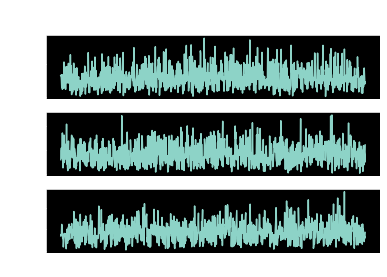

peak1 :  [  8  36  55 118 139 157 174 206 228 244 264 286 307 326 351 370 389 419
 442 486]
peak2 :  [  2  23  41  63  74 110 127 149 170 187 219 245 274 320 337 362 399 420
 447 472 498]
peak3 :  [  3  28  53  87 104 139 164 189 210 242 291 311 333 363 387 402 424 440
 457 489]
diffAcc12 :  [15.  5.  8.  9. 10. 13. 13. 13. 17.  1. 10. 34. 13. 11. 11. 29. 10.]
diffAcc23 :  [ 5. 12. 24. 12. 15. 19.  2. 23. 46. 46. 17. 13. 13. 26.  1.  3.  3.]


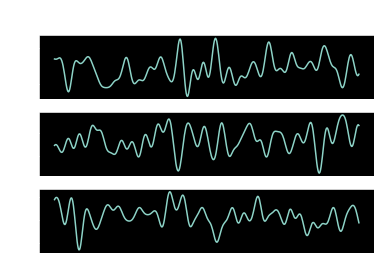

FlowRate =  7,200000
Max Norm 1 =  31105.621041688017 at freq  148.00796812749005
Max Norm 2 =  36601.75586663951 at freq  74.7011952191235
Max Norm 3 =  40490.376307343766 at freq  173.30677290836653


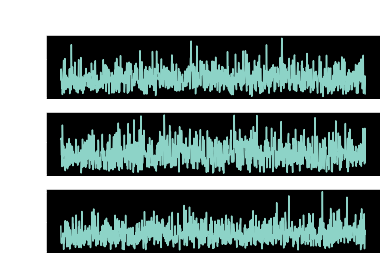

peak1 :  [  1  31  56  97 116 141 182 205 224 246 268 313 349 366 401 443 457 482]
peak2 :  [  4  37  50  60  93 114 137 165 191 223 242 268 290 316 356 389 422 437
 465 491]
peak3 :  [  8  32  49  72  98 122 145 169 191 212 240 263 293 315 336 352 366 405
 439 479]
diffAcc12 :  [ 3.  6.  4. 17. 21. 24.  9. 18. 18. 22. 22.  3.  7. 23. 21.]
diffAcc23 :  [ 4. 12. 12.  8.  8.  4. 21. 17. 21. 25.  3. 20. 10. 16. 17.]


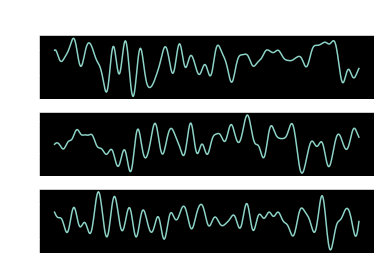

FlowRate =  11,500000
Max Norm 1 =  53595.232724490466 at freq  190.43824701195217
Max Norm 2 =  73622.78280404407 at freq  143.82470119521912
Max Norm 3 =  62930.352075494346 at freq  144.6215139442231


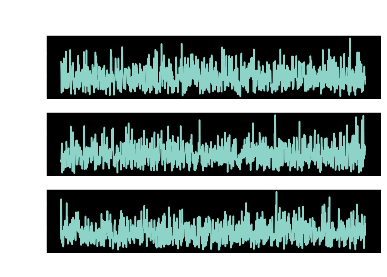

peak1 :  [  2  31  53  81 125 155 177 196 218 231 255 265 285 331 357 383 407 430
 454]
peak2 :  [ 11  37  59 105 127 148 169 197 210 223 254 290 336 368 413 445 493]
peak3 :  [ 31  54  73  94 115 132 143 161 192 224 246 269 287 307 328 366 407 438
 458 473 495]
diffAcc12 :  [ 9.  6.  6. 24.  2. 14. 20.  1.  5. 23. 35. 25.  5.  5. 11. 30.]
diffAcc23 :  [20. 17. 14. 10.  5. 23. 27. 27.  1. 15. 17. 17. 17. 30. 39. 25.]


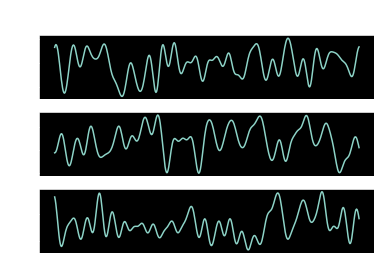

FlowRate =  16,500000
Max Norm 1 =  46816.20613661829 at freq  129.4820717131474
Max Norm 2 =  63584.40860858441 at freq  148.40637450199202
Max Norm 3 =  56924.56927133902 at freq  124.5019920318725


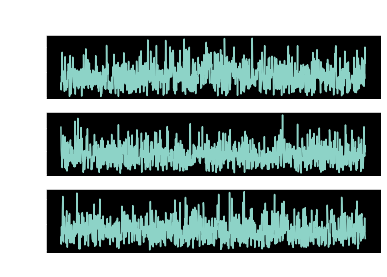

peak1 :  [ 26  49  63  88 127 153 177 203 229 251 276 299 311 333 379 397 426 436
 458 481]
peak2 :  [ 21  44  61  84  96 127 151 170 193 219 247 266 292 303 326 349 372 406
 434 454 476]
peak3 :  [  3  33  59  94 115 136 165 185 202 227 255 284 333 371 395 415 447 466
 487]
diffAcc12 :  [18. 12. 21.  8. 24. 17. 16. 16. 18. 15. 16.  4. 15. 16. 27.  9.  8.]
diffAcc23 :  [15. 33. 10. 19. 14. 15.  9.  8.  8. 18. 41. 30.  7. 22.  9.  9. 13.]


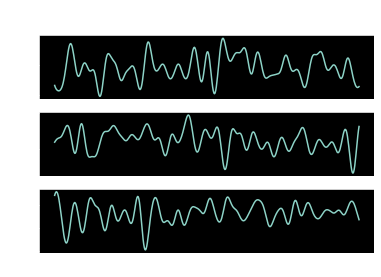

FlowRate =  21,200000
Max Norm 1 =  88292.88564565586 at freq  173.30677290836653
Max Norm 2 =  87834.65393733692 at freq  193.42629482071712
Max Norm 3 =  121000.81127885565 at freq  190.23904382470118


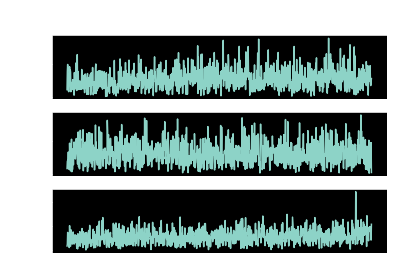

peak1 :  [ 15  34  57  78 100 122 141 163 189 216 248 280 316 339 363 391 409 423
 455]
peak2 :  [ 20  39  68 103 124 153 178 209 232 260 284 325 351 374 396 413 439 455
 484]
peak3 :  [ 25  42  64  87 107 136 171 187 202 224 245 260 304 321 337 356 376 399
 416 434 452 465 490]
diffAcc12 :  [ 5.  5. 11. 25.  3.  2. 12. 15. 20. 16. 12.  4.  9. 12. 11.  5.]
diffAcc23 :  [ 5.  3. 19.  4.  4. 12. 18.  9. 15. 13. 44. 20. 12.  5.  2.  3.]


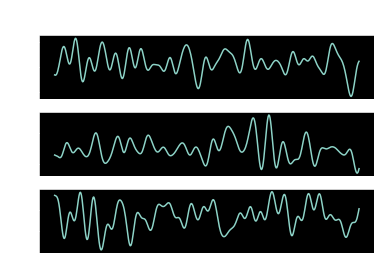

FlowRate =  25,800000
Max Norm 1 =  174354.8347896586 at freq  134.26294820717132
Max Norm 2 =  239019.52416202056 at freq  197.21115537848604
Max Norm 3 =  249608.45330387348 at freq  83.86454183266932


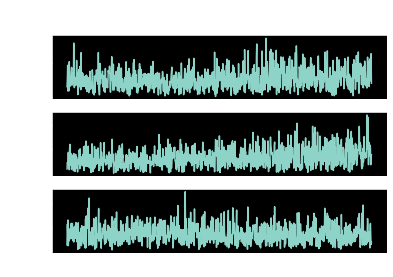

peak1 :  [  5  28  50 101 134 163 219 245 269 295 317 353 380 401 421 445 462 492]
peak2 :  [  1  15  45  66  86 109 133 162 191 218 241 259 274 310 326 348 368 388
 415 440 476 497]
peak3 :  [  9  41  58  75  98 127 165 192 222 245 266 293 307 328 346 369 406 432
 470 498]
diffAcc12 :  [10. 17. 16.  8. 28. 28. 22. 14.  5. 15.  9. 15.  8. 14. 19.]
diffAcc23 :  [26. 13.  9. 18.  3.  1.  4.  7. 19. 18.  2.  1. 18. 17. 30.]


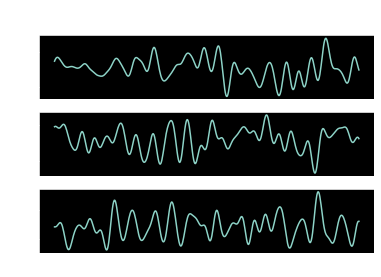

FlowRate =  31,400000
Max Norm 1 =  50934.20138601838 at freq  61.75298804780876
Max Norm 2 =  76426.17700931245 at freq  185.25896414342628
Max Norm 3 =  66889.43550287142 at freq  103.58565737051792


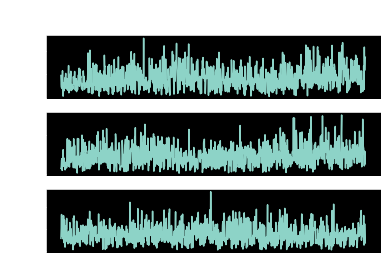

peak1 :  [ 14  35  66  89 118 145 170 195 215 235 248 269 299 316 341 358 380 402
 426 464 487]
peak2 :  [ 13  35  55  72  87 101 126 150 171 190 213 239 267 285 306 335 352 374
 395 424 464 477 495]
peak3 :  [  6  27  50  72  90 113 132 156 176 202 224 248 269 294 320 340 360 394
 427 452 481]
diffAcc12 :  [21. 20.  6. 12.  8.  5.  1. 18. 24.  4. 19. 16.  7. 19. 11. 16. 15. 22.]
diffAcc23 :  [15. 17. 18. 12.  6.  6.  5. 11.  9.  9.  2.  9. 14.  5.  8. 20. 32.  3.]


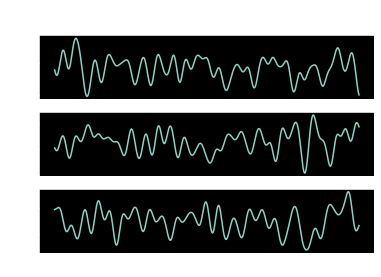

FlowRate =  35,100000
Max Norm 1 =  90372.36155471779 at freq  94.8207171314741
Max Norm 2 =  102746.94180250599 at freq  185.85657370517927
Max Norm 3 =  71752.92690139367 at freq  12.749003984063744


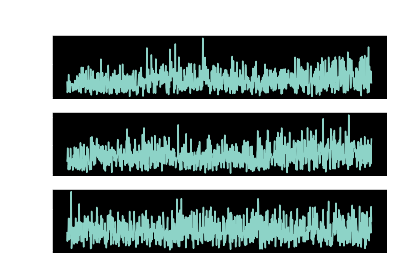

peak1 :  [ 14  34  53  68  86 111 138 159 183 205 229 267 294 313 349 367 386 418
 440 455 482]
peak2 :  [ 23  51  72  86 105 119 156 174 212 239 256 278 303 326 369 393 423 443
 465 489]
peak3 :  [ 11  34  60  79  98 117 146 164 186 214 249 288 312 333 357 412 434 464
 493]
diffAcc12 :  [ 9. 17. 19.  4. 19.  8. 18. 15. 29.  7. 10. 11.  9. 13. 20.  2.  7.  5.]
diffAcc23 :  [11.  9.  7.  7. 12. 27.  8. 12.  2.  2. 10. 10.  9.  7. 43. 43. 19. 11.]


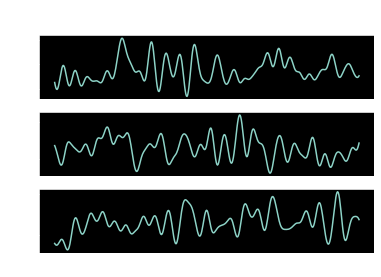

FlowRate =  39,800000
Max Norm 1 =  66982.53464755566 at freq  192.82868525896413
Max Norm 2 =  57375.08585406006 at freq  183.46613545816732
Max Norm 3 =  44534.0283912752 at freq  195.6175298804781


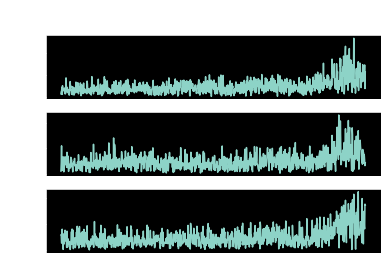

peak1 :  [ 14  41  63  84 100 124 142 166 179 201 211 231 252 273 299 312 341 367
 389 397 422 448 469 498]
peak2 :  [ 22  45  67 101 121 147 188 212 234 249 284 316 340 354 375 396 417 436
 454 470 491]
peak3 :  [  6  38  55  82 104 125 149 167 188 211 241 262 282 308 337 355 378 402
 437 472 492]
diffAcc12 :  [ 8.  4.  4. 17.  1. 23.  5. 22.  9. 11.  1.  3. 32. 11. 17.  4. 13.  8.
  7. 20. 14.]
diffAcc23 :  [16. 10. 15.  3.  3.  2.  2. 23. 23. 29. 29.  7. 24. 24. 21. 21.  1.  3.
  6. 20.  1.]


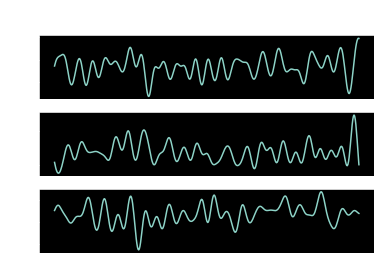

FlowRate =  39,800000
Max Norm 1 =  1710.0000327831724 at freq  46.41434262948207
Max Norm 2 =  2066.745063013805 at freq  120.91633466135457
Max Norm 3 =  1970.555031987471 at freq  50.0


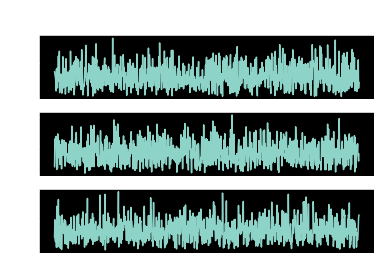

peak1 :  [ 21  37  73  96 123 154 173 194 211 227 258 291 310 327 359 394 427 447
 483]
peak2 :  [  6  29  56  79 124 143 157 181 201 225 245 270 298 324 351 372 392 421
 454 491]
peak3 :  [ 11  37  54  73 106 128 145 157 179 199 219 244 263 289 329 347 373 396
 417 438 452 491]
diffAcc12 :  [ 8. 19.  6. 28.  1.  3.  8.  7. 14. 18. 12.  7. 14. 24. 13. 27.]
diffAcc23 :  [ 8. 17. 27.  4.  4. 22. 18. 18. 19. 18. 19. 31.  5. 22.  1. 17.]


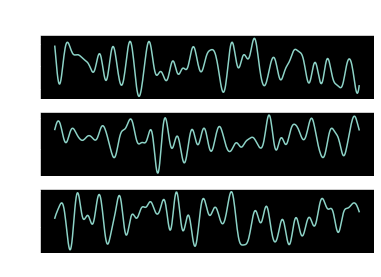

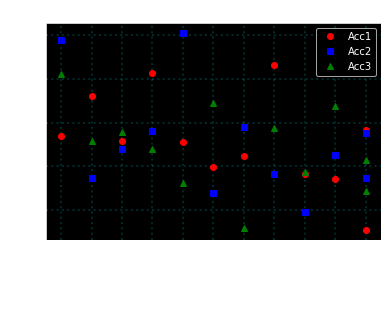

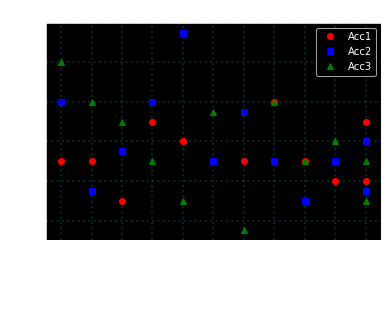

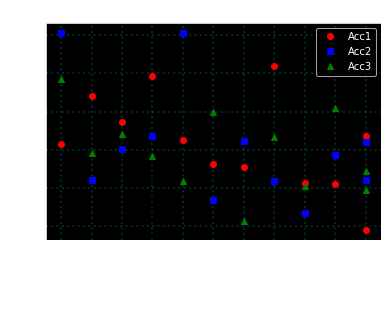

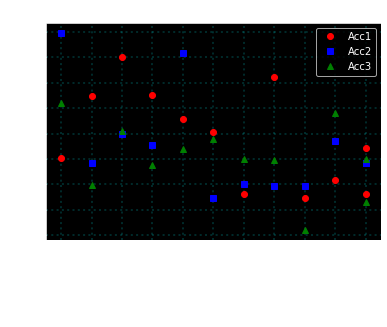

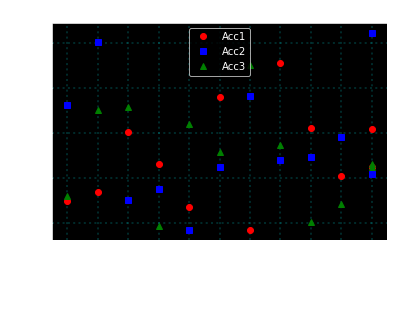

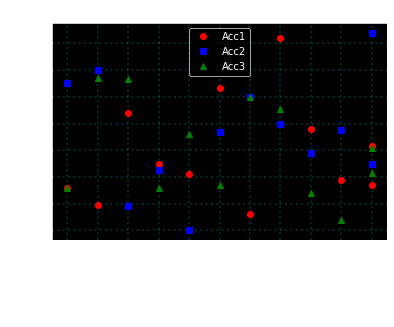

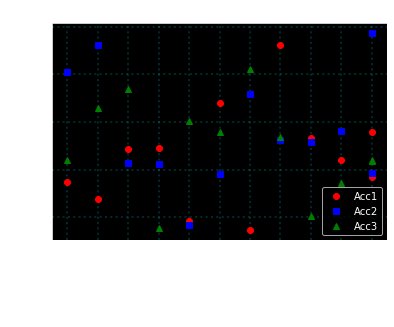

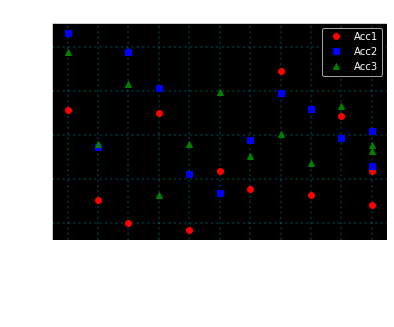

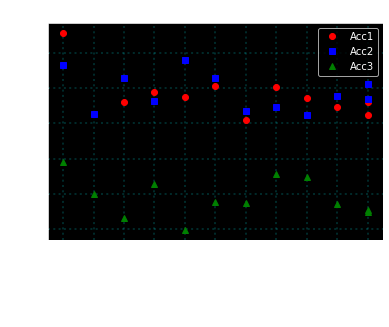

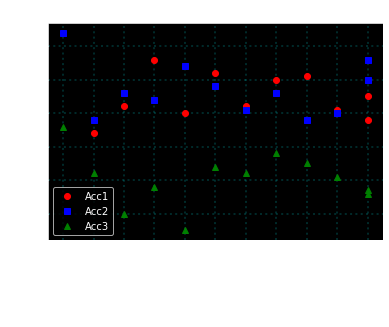

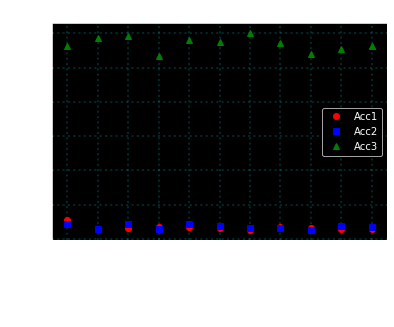

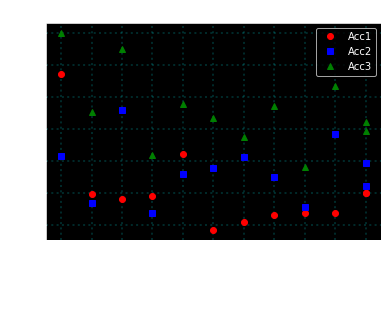

In [14]:
directory = "Meas_Outdoor_200924/Measure_1/HPF_Disable/"
list_meas_1 = os.listdir(directory)
all_peaks = pd.DataFrame()
for file in list_meas_1:
    peak_feat, hpf = plotHandledSignal(directory+file, 
                                       pStd=False,                       # Display Standard signal
                                       pLow=True,                       # Display Low-Pass filtered signal
                                       pFFT=False,                       # Display FFT Signal
                                       axis='xyz',                      # Choose axis to display
                                       freq=40,                         # Cut-off frequency LPF
                                       winSize=500,                      # Nb of samples to show
                                       winNb=2,                         # Offset "winSize" for the samples
                                       peak=True)                      # Show Peaks informations
    all_peaks = all_peaks.append(peak_feat)

plotDataset(all_peaks)